# Homework 4: Can you predict the Midterm Elections?

Due: Monday, November 3, 2014 11:59 PM

<a href=https://raw.githubusercontent.com/cs109/2014/master/homework/HW4.ipynb download=HW4.ipynb> Download this assignment</a>

#### Submission Instructions
To submit your homework, create a folder named lastname_firstinitial_hw# and place your IPython notebooks, data files, and any other files in this folder. Your IPython Notebooks should be completely executed with the results visible in the notebook. We should not have to run any code. Compress the folder (please use .zip compression) and submit to the CS109 dropbox in the appropriate folder. If we cannot access your work because these directions are not followed correctly, we will not grade your work. For the competition (problem 4), we will post a link on Piazza to a Google Form for you to submit your predictions. 


---


## Introduction

**Add Introduction**

You will use the [HuffPost Pollster API](http://elections.huffingtonpost.com/pollster/api) to extract the polls for the current 2014 Senate Midterm Elections and provide a final prediction of the result of each state.

#### Data

We will use the polls from the [2014 Senate Midterm Elections](http://elections.huffingtonpost.com/pollster) from the [HuffPost Pollster API](http://elections.huffingtonpost.com/pollster/api). 

---

## Problem 1: Data Wrangling

We will read in the polls from the [2014 Senate Midterm Elections](http://elections.huffingtonpost.com/pollster) from the [HuffPost Pollster API](http://elections.huffingtonpost.com/pollster/api) and create a dictionary of DataFrames as well a master table information for each race.

#### Problem 1(a)

Read in [this JSON object](http://elections.huffingtonpost.com/pollster/api/charts/?topic=2014-senate) containing the polls for the 2014 Senate Elections using the HuffPost API. Call this JSON object `info`.  This JSON object is imported as a list in Python where each element contains the information for one race.  Use the function `type` to confirm the that `info` is a list. 

In [26]:
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 

import requests 
import io
import zipfile
import numpy as np
import scipy
import pandas as pd # pandas
import matplotlib.pyplot as plt # module for plotting 

# If this module is not already installed, you may need to install it. 
# You can do this by typing 'pip install seaborn' in the command line
import seaborn as sns 

import sklearn
import sklearn.datasets
import sklearn.cross_validation
import sklearn.decomposition
import sklearn.grid_search
import sklearn.neighbors
import sklearn.metrics

In [3]:
url = 'http://elections.huffingtonpost.com/pollster/api/charts/?topic=2014-senate'
info = requests.get(url).json()

#### Problem 1(b)

For each element of the list in `info` extract the state. We should have one poll per state, but we do not. Why?

**Hint**: Use the internet to find out information on the races in each state that has more than one entry. Eliminate entries of the list that represent races that are not happening.

In [4]:
states = [str(ele['state']) for ele in info]
titles = [str(ele['title']) for ele in info]
print(states)

['DE', 'MA', 'RI', 'MT', 'OK', 'HI', 'KS', 'WY', 'TN', 'ID', 'NJ', 'NM', 'OK', 'SC', 'SC', 'TX', 'MN', 'ME', 'SD', 'NE', 'GA', 'OR', 'MS', 'IA', 'AK', 'IL', 'CO', 'VA', 'NC', 'NH', 'WV', 'NH', 'LA', 'MI', 'AR', 'KY']


In [5]:
from collections import Counter
countstates = Counter(states)
duplicate = [k for (k,v) in countstates.items() if v > 1]
duplicate

['OK', 'SC', 'NH']

In [6]:
for dups in duplicate:
    ind = [i for i,x in enumerate(states) if x == dups ]
    for ele in ind:
        print(titles[ele], ele)

2014 Oklahoma Senate: Lankford vs. Johnson 4
2014 Oklahoma Senate: Inhofe vs. Silverstein 12
2014 South Carolina Senate: Scott vs. Dickerson 13
2014 South Carolina Senate: Graham vs. Hutto 14
2014 New Hampshire Senate: Bass vs. Shaheen 29
2014 New Hampshire Senate: Brown vs. Shaheen 31


In [7]:
idx = 4, 13, 29
editinfo = [i for (j,i) in enumerate(info) if j not in idx]
print(len(info))
print(len(editinfo))

36
33


** Your answer here: **

#### Problem 1(c)

Create a dictionary of pandas DataFrames called `polls` keyed by the name of the election (a string). Each value in the dictionary should contain the polls for one of the races.

In [8]:
def build_frame(url):
    """
    Returns a pandas DataFrame object containing
    the data returned from the given url
    """
    source = requests.get(url).text
    
    # Use StringIO because pd.DataFrame.from_csv requires .read() method
    s = io.StringIO(source)
    
    return pd.DataFrame.from_csv(s, index_col=None).convert_objects(
            convert_dates="coerce", convert_numeric=True)

In [9]:
# Makes a dictionary of pandas DataFrames keyed on election string.
polls = dict((election['slug'], build_frame(election['url']+'.csv')) for election in editinfo)
polls

C:\Users\Wolf\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


{'2014-alaska-senate-sullivan-vs-begich':                                             Pollster Start Date   End Date  \
 0                                            PPP (D) 2014-11-01 2014-11-02   
 1                                          Rasmussen 2014-10-27 2014-10-30   
 2                 Moore (R-Sullivan For U.S. Senate) 2014-10-26 2014-10-28   
 3                                         Ivan Moore 2014-10-24 2014-10-26   
 4                                     CBS/NYT/YouGov 2014-10-16 2014-10-23   
 5   Harstad (D-Senate Majority PAC/Put Alaska First) 2014-10-18 2014-10-22   
 6                                         Hellenthal 2014-10-15 2014-10-21   
 7                                          Rasmussen 2014-10-08 2014-10-12   
 8                                                FOX 2014-10-04 2014-10-07   
 9                                                CNN 2014-10-01 2014-10-06   
 10              Hickman (D-Consumer Energy Alliance) 2014-09-26 2014-10-02   
 11        

#### Problem 1(d)

Now create a master table information containing information about each race. Create a pandas DataFrame called `candidates` with rows containing information about each race. The `candidates` DataFrame should have the following columns: 

1. `State` = the state where the race is being held
2. `R` = name of republican candidate
3. `D` = name of non-republican candidate (Democrate or Independent) 
4. `incumbent` = R, D or NA

**Hint**: You will need a considerable amount of data wrangling for this.

In [10]:
df = pd.DataFrame([ele['state'] for ele in editinfo])
df.head()

,0
0,DE
1,MA
2,RI
3,MT
4,HI


In [11]:
cands = [ele['estimates'] for ele in editinfo]
cands

[[{'choice': 'Coons',
   'first_name': 'Chris',
   'incumbent': True,
   'last_name': 'Coons',
   'lead_confidence': 99.9,
   'party': 'Dem',
   'value': 56.0},
  {'choice': 'Wade',
   'first_name': 'Kevin',
   'incumbent': False,
   'last_name': 'Wade',
   'lead_confidence': 0.0,
   'party': 'Rep',
   'value': 34.0}],
 [{'choice': 'Markey',
   'first_name': 'Ed',
   'incumbent': True,
   'last_name': 'Markey',
   'lead_confidence': 99.9,
   'party': 'Dem',
   'value': 54.1},
  {'choice': 'Herr',
   'first_name': 'Brian',
   'incumbent': False,
   'last_name': 'Herr',
   'lead_confidence': 0.0,
   'party': 'Rep',
   'value': 33.4},
  {'choice': 'Other',
   'first_name': None,
   'incumbent': False,
   'last_name': None,
   'lead_confidence': None,
   'party': 'N/A',
   'value': 0.18}],
 [],
 [{'choice': 'Daines',
   'first_name': 'Steve',
   'incumbent': False,
   'last_name': 'Daines',
   'lead_confidence': 99.9,
   'party': 'Rep',
   'value': 53.8},
  {'choice': 'Curtis',
   'first_n

In [12]:
rows = []
for race in cands:
    race_row = []
    for choice in race:
        if choice['party'] == 'Rep':
            race_row.append(str(choice['choice']))
    for choice in race:
        if (choice['party'] == 'Dem') or (choice['party'] == 'ind'):
            race_row.append(str(choice['choice']))
    for choice in race:
        if choice['incumbent'] == True:
            race_row.append(str(choice['party']))
    if len(race_row) <= 2:
        race_row.append(np.nan)
    rows.append(race_row)

missing = ['Zaccaria', 'Reed', 'Dem']
rows[2] = missing
rows

[['Wade', 'Coons', 'Dem'],
 ['Herr', 'Markey', 'Dem'],
 ['Zaccaria', 'Reed', 'Dem'],
 ['Daines', 'Curtis', nan],
 ['Cavasso', 'Schatz', 'Dem'],
 ['Roberts', 'Orman', 'Rep'],
 ['Enzi', 'Hardy', 'Rep'],
 ['Alexander', 'Ball', 'Rep'],
 ['Risch', 'Mitchell', 'Rep'],
 ['Bell', 'Booker', 'Dem'],
 ['Weh', 'Udall', 'Dem'],
 ['Inhofe', 'Silverstein', 'Rep'],
 ['Graham', 'Hutto', 'Rep'],
 ['Cornyn', 'Alameel', 'Rep'],
 ['McFadden', 'Franken', 'Dem'],
 ['Collins', 'Bellows', 'Rep'],
 ['Rounds', 'Weiland', nan],
 ['Sasse', 'Domina', nan],
 ['Perdue', 'Nunn', nan],
 ['Wehby', 'Merkley', 'Dem'],
 ['Cochran', 'Childers', 'Rep'],
 ['Ernst', 'Braley', nan],
 ['Sullivan', 'Begich', 'Dem'],
 ['Oberweis', 'Durbin', 'Dem'],
 ['Gardner', 'Udall', 'Dem'],
 ['Gillespie', 'Warner', 'Dem'],
 ['Tillis', 'Hagan', 'Dem'],
 ['Capito', 'Tennant', nan],
 ['Brown', 'Shaheen', 'Dem'],
 ['Cassidy', 'Landrieu', 'Dem'],
 ['Land', 'Peters', nan],
 ['Cotton', 'Pryor', 'Dem'],
 ['McConnell', 'Grimes', 'Rep']]

In [13]:
df2 = pd.DataFrame(rows)
print(df.shape)
print(df2.shape)

(33, 1)
(33, 3)


In [14]:
candidates = pd.concat([df, df2], axis = 1)
candidates.columns = ['State', 'R', 'D or I', 'Incumbent']
candidates.head(10)

,State,R,D or I,Incumbent
0,DE,Wade,Coons,Dem
1,MA,Herr,Markey,Dem
2,RI,Zaccaria,Reed,Dem
3,MT,Daines,Curtis,NaN
4,HI,Cavasso,Schatz,Dem
5,KS,Roberts,Orman,Rep
6,WY,Enzi,Hardy,Rep
7,TN,Alexander,Ball,Rep
8,ID,Risch,Mitchell,Rep
9,NJ,Bell,Booker,Dem


## Problem 2: Confidence Intervals

Compute a 99% confidence interval for each state. 

#### Problem 2(a)

Assume you have $M$ polls with sample sizes $n_1, \dots, n_M$. If the polls are independent, what is the average of the variances of each poll if the true proportion is $p$?

** Your answer here: **

#### Problem 2(b)

Compute the square root of these values in Problem 2(a) for the republican candidates in each race. Then, compute the standard deviations of the observed poll results for each race. 

In [15]:
def sds(editinfo, polls):
    obs_sds = []
    ther_sds = []
    npolls = []
    for i, election in enumerate(editinfo):
        election_polls = polls[election['slug']]
        
        npoll = election_polls.shape[0]
        
        n = election_polls['Number of Observations']
        p = election_polls[candidates['R'].ix[i]]/100
        
        p_mean = np.mean(p)
        ther_sd = np.sqrt(p_mean*(1-p_mean)*np.mean(1./n))
        
        obs_sd = np.std(p)
        
        obs_sds.append(obs_sd)
        ther_sds.append(ther_sd)
        npolls.append(npoll)
    return obs_sds, ther_sds, npolls
        
    #print(npolls)
obs_sds, ther_sds, npolls = sds(editinfo, polls)

#### Problem 2(c) 

Plot observed versus theoretical (average of the theoretical SDs) with the area of the point proportional to number of polls. How do these compare?

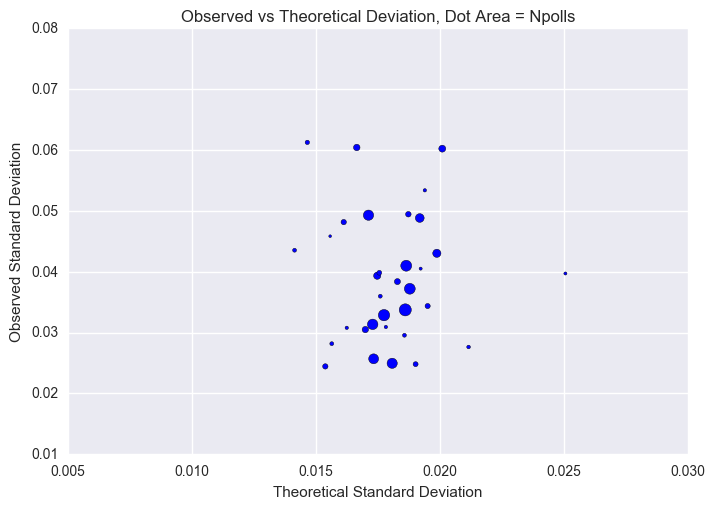

In [16]:
plt.scatter(ther_sds, obs_sds,  s=npolls)
plt.xlabel('Theoretical Standard Deviation')
plt.ylabel('Observed Standard Deviation')
plt.title('Observed vs Theoretical Deviation, Dot Area = Npolls')
plt.show()

** Your answer here: **

#### Problem 2(d)

Repeat Problem 2(c) but include only the most recent polls from the last two months. Do they match better or worse or the same? Can we just trust the theoretical values?

In [17]:
dup_polls = polls
for key in dup_polls:
    #df = dup_polls[key]
    dup_polls[key] = dup_polls[key][dup_polls[key]['Start Date'] > '2014-09-04']

In [18]:
robs_sds, rther_sds, rnpolls = sds(editinfo, dup_polls)

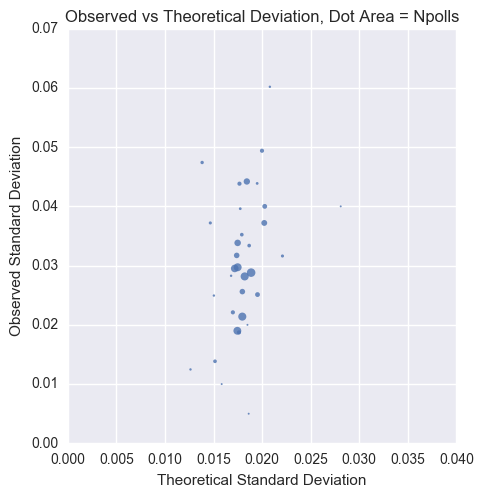

In [19]:
gdf = pd.DataFrame()
gdf['x'] = rther_sds
gdf['y'] = robs_sds
gdf['z'] = rnpolls
cmap = sns.cubehelix_palette(8, start=.5, rot=-.75)
sns.lmplot('x', 'y', data=gdf, fit_reg=False, scatter_kws={"s": (100*rnpolls)})
plt.xlabel('Theoretical Standard Deviation')
plt.ylabel('Observed Standard Deviation')
plt.title('Observed vs Theoretical Deviation, Dot Area = Npolls')

plt.show()

** Your answer here: **

#### Problem 2(e)

Create a scatter plot with each point representing one state. Is there one or more races that are outlier in that it they have much larger variabilities than expected ? Explore the original poll data and explain why the discrepancy?

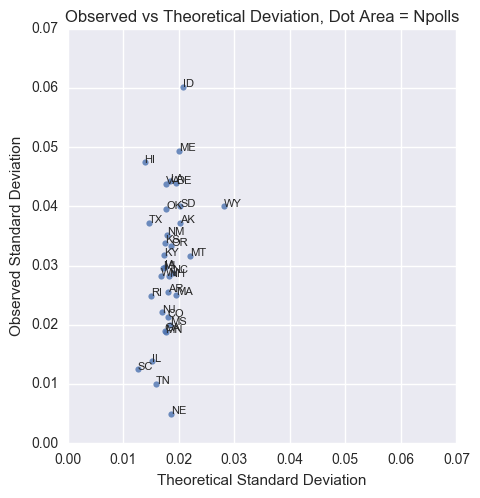

In [20]:
sns.lmplot('x', 'y', data=gdf, fit_reg=False)
plt.xlabel('Theoretical Standard Deviation')
plt.ylabel('Observed Standard Deviation')
plt.title('Observed vs Theoretical Deviation, Dot Area = Npolls')
for i in range(len(rnpolls)):
    plt.text(rther_sds[i], robs_sds[i], candidates.ix[i,'State'], fontsize=8)
axes = plt.gca()
axes.set_xlim([0,0.07])
axes.set_ylim([0,0.07])
plt.show()

** Your answer here: **
Idaho is a major outlier, as is Hawaii and Maine. 

#### Problem 2(f)

Construct confidence intervals for the difference in each race. Use either theoretical or data driven estimates of the standard error depending on your answer to this question. Use the results in Problem 2(e), to justify your choice.


In [21]:
from scipy import stats
def poll_diff(editinfo, polls):
    rows = []
    for i, election in enumerate(editinfo):
        polls_key = election['slug']
        this_election = polls[polls_key]
        
        npolls = this_election.shape[0]
        
        diff = (this_election[candidates['R'].ix[i]] - this_election[candidates['D or I'].ix[i]])/100
        mean_diff = np.mean(diff)
        
        se = np.std(diff)/np.sqrt(npolls)
        sd = np.std(diff)
        
        margin = stats.t.ppf(1-0.005, npolls)
        
        rows.append((polls_key, mean_diff, se, sd, margin))
    return rows

estimates = pd.DataFrame(poll_diff(editinfo, polls), columns = ['race', 'mean', 'se', 'sd', 'margin'])
estimates.sort_values('mean', inplace = True)
estimates.head()

,race,mean,se,sd,margin
4,2014-hawaii-senate-cavasso-vs-schatz,-0.420000,0.044284,0.108474,3.707428
2,2014-rhode-island-senate-zaccaria-vs-reed,-0.406667,0.024191,0.041899,5.840909
1,2014-massachusetts-senate-herr-vs-markey,-0.220833,0.011393,0.039467,3.054540
0,2014-delaware-senate-wade-vs-coons,-0.185000,0.019526,0.039051,4.604095
19,2014-oregon-senate-wehby-vs-merkley,-0.162857,0.018263,0.048319,3.499483


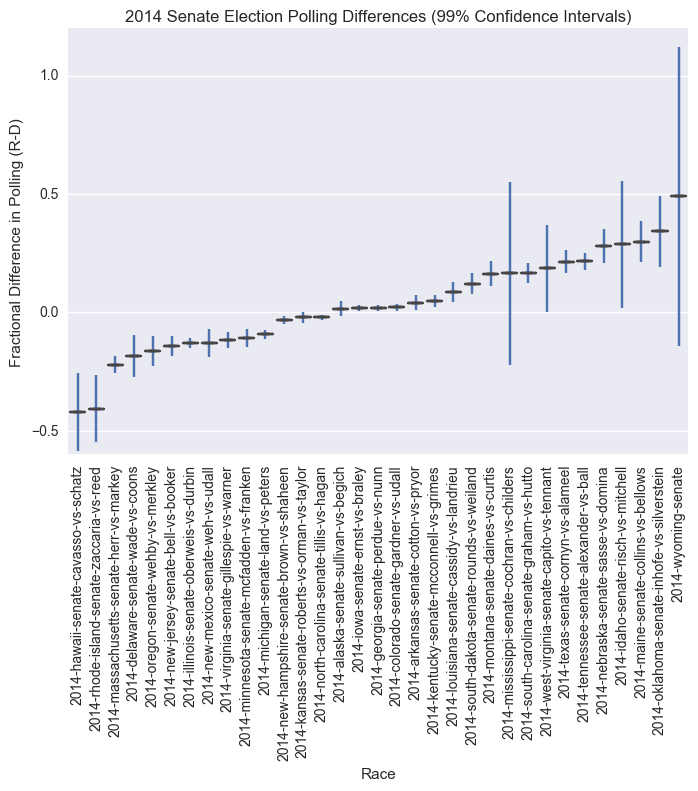

In [22]:
sns.boxplot(x='race', y = 'mean', data = estimates)
plt.xticks(range(estimates.shape[0]), estimates['race'].values, rotation=90)
plt.errorbar(range(estimates.shape[0]), estimates['mean'], yerr = estimates['se']*estimates['margin'], fmt='+')
plt.xlabel('Race')
plt.ylabel('Fractional Difference in Polling (R-D)')
plt.title('2014 Senate Election Polling Differences (99% Confidence Intervals)')
plt.show()

# Problem 3: Prediction and Posterior Probabilities

Perform a Bayesian analysis to predict the probability of Republicans winning in each state then provide a posterior distribution of the number of republicans in the senate.

#### Problem 3(a)

First, we define a Bayesian model for each race. The prior for the difference $\theta$ between republicans and democtrats will be $N(\mu,\tau^2)$. Say before seeing poll data you have no idea who is going to win, what should $\mu$ be? How about $\tau$, should it be large or small? 

** Your answer here: ** 
Since we have no informed idea who will win, the prior mean ($\mu$) = 0, and based on the fact that most elections are fairly close, $\tau$ should be small. 

#### Problem 3(b)

What is the distribution of $d$ conditioned on $\theta$. What is the posterior distribution of $\theta | d$? 

**Hint**: Use normal approximation. 

**Your answer here:**
$d|θ = N(θ, \sigma^2/M)$ where $\sigma^2$ is observed sample variance and M is the number of polls used to calculate $d$. 
in that case, then:
$θ|d$ ~ $N(B\mu+(1−B)d,(1−B)\sigma^2/M)$ , where $B=\frac{1/\tau^2}{M/\sigma^2+1/\tau^2B}$

#### Problem 3(c)

The prior represents what we think before hand. We do not know who is expected to win, so we assume $\mu=0$. For this problem estimate $\tau$ using the observed differences across states (Hint: $\tau$ represents the standard deviation of a typical difference). Compute the posterior mean for each state and plot it against original average. Is there much change? Why or why not? 

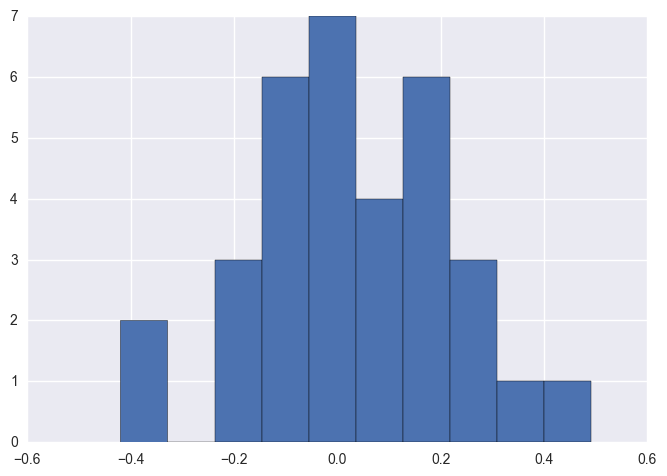

In [23]:
###check our data is roughly normal distributed###
plt.hist(estimates['mean'])
plt.show()

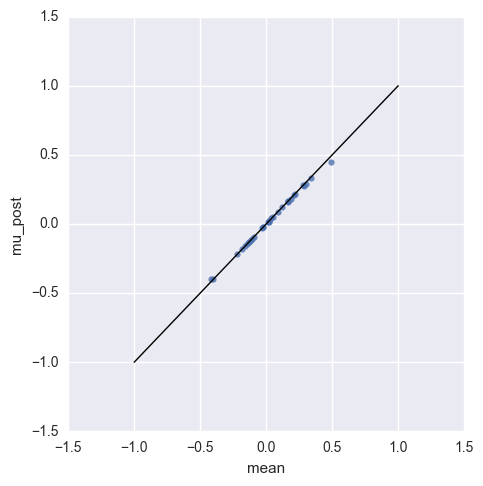

In [24]:
tau = np.std(estimates['mean'])
B = (1/tau**2)/(1/estimates['se']**2+1/tau**2)
estimates['mu_post'] = (1-B)*estimates['mean']

sns.lmplot('mean', 'mu_post', data = estimates, fit_reg = False, scatter_kws={ 
                        "s": 20})
plt.plot((-1,1),(-1,1), c='black', linewidth=1)
plt.show()

**Your answer here:**
Not much change, probably because the posterior is being informed primarily by the data, rather than the prior. 

#### Problem 3(d)

For each state, report a probabilty of Republicans winning. How does your answer here compare to the other aggregators?

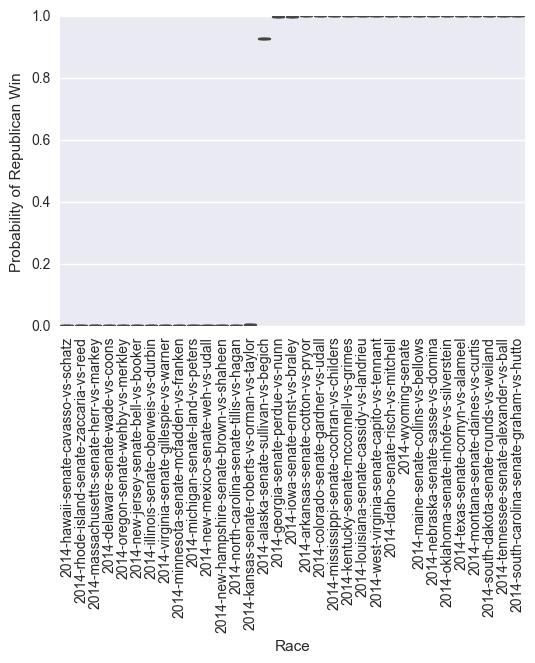

In [27]:
### Your code here ###
estimates['sd_post'] = np.sqrt((1-B)*estimates['se']**2)

estimates['R_win_prob'] = 1-scipy.stats.norm.cdf(0, loc=estimates['mu_post'], scale=estimates['sd_post'])
estimates.sort_values('R_win_prob', inplace = True)
sns.boxplot('race', 'R_win_prob', data=estimates)
plt.xticks(range(estimates.shape[0]), estimates['race'].values, rotation=90)
plt.ylabel('Probability of Republican Win')
plt.xlabel('Race')
plt.show()

**Your answer here:**
Not very favorably, it appears we need more uncertainty incorporated into our model, as many of the states have a very black/white answer. 

#### Problem 3(e)

Use the posterior distributions in a Monte Carlo simulation to generate election results. In each simulation compute the total number of seats the Republican control. Show a histogram of these results.

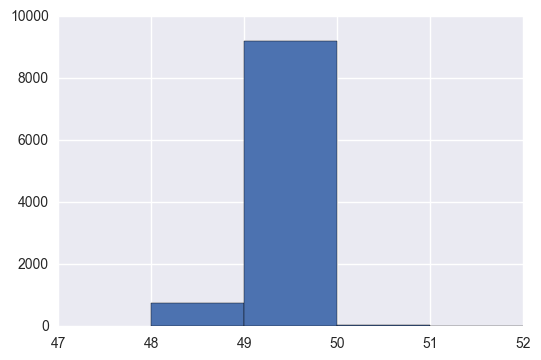

In [29]:
num_states = estimates.shape[0]

NSIM = 10000
simarr = np.zeros(NSIM, dtype=int)
for i in range(NSIM):
    simulated = 30 + np.sum(np.random.normal(estimates['mu_post'], scale=estimates['sd_post'], size =num_states) > 0 )
    simarr[i] = int(simulated)
plt.hist(simarr, bins=range(min(simarr)-1, max(simarr)+3))
plt.show()

## Problem 4

Predict the results for the 2014 Midterm Elections. We will have a three competitions with the terms for scoring entries described above. For both questions below, **explain** or provide commentary on how you arrived at your predictions including code. 

**Hint**: Use election results from 2010, 2012 to build and test models.

#### Problem 4(a)

Predict the number of Republican senators. You may provide an interval. Smallest interval that includes the election day result wins. 

**Note**: we want the total so add the numbers of those that are not up for election.

In [ ]:
### Your code here ###

**Provide an explanation of methodology here**:

#### Problem 4(b)

Predict the R-D difference in each state. The predictions that minimize the residual sum of squares between predicted and observed differences wins.

In [ ]:
### Your code here ###

**Provide an explanation of methodology here**:

#### Problem 4(c)

Report a confidence interval for the R-D difference in each state. If the election day result falls outside your confidence interval in more than two states you are eliminated. For those surviving this cutoff, we will add up the size of all confidence intervals and sum. The smallest total length of confidence interval wins. 

**Note**: you can use Bayesian credible intervals or whatever else you want. 

In [ ]:
### Your code here ###

**Provide an explanation of methodology here**:

# Submission Instructions

To submit your homework, create a folder named **lastname_firstinitial_hw#** and place your IPython notebooks, data files, and any other files in this folder. Your IPython Notebooks should be completely executed with the results visible in the notebook. We should not have to run any code.  Compress the folder (please use .zip compression) and submit to the CS109 dropbox in the appropriate folder. *If we cannot access your work because these directions are not followed correctly, we will not grade your work.*
